In [70]:
import os
import getpass
from typing import Annotated,TypedDict, List, Dict, Any, Optional
from langchain_ibm import ChatWatsonx
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import Tool
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent,tools_condition, ToolNode
from langgraph.checkpoint.memory import InMemorySaver
from langfuse import Langfuse
from IPython.display import Image, display

In [71]:
os.environ["TAVILY-API-KEY"] = "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"

In [72]:
parameters = {
    "decoding_method": "greedy",
    "max_new_tokens": 500,
    "repetition_penalty": 1,
    "min_new_tokens":1
}

Watson_llm = ChatWatsonx(
    model_id="ibm/granite-3-8b-instruct",
    url="https://us-south.ml.cloud.ibm.com",
    apikey="GSK7bM6Zd-xMtm0N42OCZloVEU2AAu-hM4ET9QEptoih",
    project_id="bec7cfaf-a6c9-4f54-be5d-dbf91555ea41",
    params=parameters,
)

In [73]:
if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")
tavily_tool = TavilySearch (
    max_result = 5,
    topic = "news",
    time_range="week",
    search_depth="advanced",
)

search_tool = Tool(
    name = "Web_searcher",
    description = "A web search engine which looks out for risks like natural disasters, wars etc at a given location",
    func = tavily_tool.invoke,
)

In [74]:
tools = [search_tool]
memory = InMemorySaver()


In [75]:
class Risk_state(TypedDict):
    location: Dict[str, Any]
    curr_risk: Dict[str, Any]
    is_high: Optional[bool]
    high_reason: Optional[str]
    risk_category: Optional[str]

def tools_condition(state : Risk_state):
    if state["HIGH"]:
        return "HIGH"
    elif state["MEDIUM"] :
        return "MEDIUM"
    else:
        return "LOW"
    

In [76]:
graph_builder = StateGraph(Risk_state)

In [77]:
def search_classify_risk(state : Risk_state, search_tool ) :
    location = state["location"]
    prompt = f"""
    You are a professional city management and maintanence agent. Your job is to analyze the situation of the city and classify the degree of risk. You have been given the risk and location. 
    
    You have access to following tools {search_tool}
    
    Analyze based on following factors
    
    Location : {location}
    Scarce resources based on current risk : give the detailed list of scarce resources

    Look out the economic and societal condition of the city before classifying.
    Analyze in three categories:
    HIGH
    MEDIUM
    LOW

    Return the answer containig type of risk, degree of risk and scarce resources while working in THOUGHT-ACTION-OBSERVATION loop.     

    If the risk is HIGH, then explain the reason
    """

    messages = [HumanMessage(content=prompt)]
    response = Watson_llm.invoke(messages)

    response_text = response.content.lower()
    print(response_text)

In [78]:
graph_builder.add_node("Risk", search_classify_risk)
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_edge(START,"Risk")
graph_builder.add_conditional_edges("Risk",
                                    tools_condition,
                                    {
                                        "HIGH":"tools",
                                        "MEDIUM":"tools",
                                        "LOW": END,
                                    })
graph_builder.add_edge("tools","Risk")
graph_builder.add_edge("Risk", END)

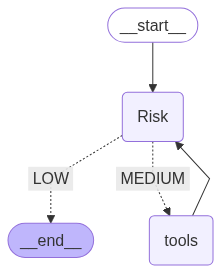

In [79]:
config = {"configurable": {"thread_id": "1"}}
graph = graph_builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

<h1>Example</h1>

Krypton = {
    "Disaster" : "flood"
    "conditions" : "scarcity in resources. imideate evacuaton required"
}

flood_result = graph.invoke({
    "location" : Krypton,
    "curr_risk" : None,
    "is_high" : None,
})

In [80]:
Krypton = {
    "Disaster" : "flood",
    "conditions" : "scarcity in resources. imideate evacuaton required",
    "tools" : tools,
}

flood_result = graph.invoke({
    "location" : Krypton,
    "curr_risk" : None,
    "is_high" : None,
})

TypeError: search_classify_risk() missing 1 required positional argument: 'search_tool'